In [3]:
import numpy as np
import h5py
import sys
import matplotlib.pyplot as plt
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
sys.path.append('./../code/')

The following notebook compares manually-computed injection weights to those weights precomputed and stored in the injection .hdf5 files. Note that I'm comparing against the content of [`prep_injections.py`](https://git.ligo.org/thomas-callister/o3b-pop-studies/-/blob/main/code/prep_injections.py) in the following commit hash:

1a14f8629947b8b048fc222605fbc29d34401f29

In [4]:
# Load O3 injections
ifar_threshold = 1
mockDetections_O3 = h5py.File('/home/reed.essick/rates+pop/o3-sensitivity-estimates/LIGO-T2100113-v10/endo3_bbhpop-LIGO-T2100113-v10.hdf5','r')
ifar_1 = mockDetections_O3['injections']['ifar_gstlal'].value
ifar_2 = mockDetections_O3['injections']['ifar_pycbc_bbh'].value
ifar_3 = mockDetections_O3['injections']['ifar_pycbc_hyperbank'].value
detected = (ifar_1>ifar_threshold) + (ifar_2>ifar_threshold) + (ifar_3>ifar_threshold)
m1_det = mockDetections_O3['injections']['mass1_source'].value[detected]
m2_det = mockDetections_O3['injections']['mass2_source'].value[detected]
s1x_det = mockDetections_O3['injections']['spin1x'].value[detected]
s1y_det = mockDetections_O3['injections']['spin1y'].value[detected]
s1z_det = mockDetections_O3['injections']['spin1z'].value[detected]
s2x_det = mockDetections_O3['injections']['spin2x'].value[detected]
s2y_det = mockDetections_O3['injections']['spin2y'].value[detected]
s2z_det = mockDetections_O3['injections']['spin2z'].value[detected]
z_det = mockDetections_O3['injections']['redshift'].value[detected]

<ipython-input-4-6ad0a78dedab>:4: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ifar_1 = mockDetections_O3['injections']['ifar_gstlal'].value
<ipython-input-4-6ad0a78dedab>:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ifar_2 = mockDetections_O3['injections']['ifar_pycbc_bbh'].value
<ipython-input-4-6ad0a78dedab>:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ifar_3 = mockDetections_O3['injections']['ifar_pycbc_hyperbank'].value
<ipython-input-4-6ad0a78dedab>:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  m1_det = mockDetections_O3['injections']['mass1_source'].value[detected]
<ipython-input-4-6ad0a78dedab>:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  m2_det = mockDetections_O3['injections']['mass2_source'].value[detected]
<ipython-input-4-6ad0a78dedab>:10: H5pyDeprecationWarnin

In [6]:
# Manually compute injection probabilities
ref_m_min = 2.
ref_m_max = 100.
ref_a1 = -2.35
ref_a2 = 1.
ref_kappa_minus_1 = 1.

# Derived quantities
q_det = m2_det/m1_det
mtot_det = m1_det+m2_det

# Injected mass distributions
ref_p_m1 = (1.+ref_a1)*np.power(m1_det,ref_a1)/(ref_m_max**(1.+ref_a1) - ref_m_min**(1.+ref_a1))
ref_p_m2 = (1.+ref_a2)*np.power(m2_det,ref_a2)/(m1_det**(1.+ref_a2) - ref_m_min**(1.+ref_a2))
ref_p_mass = ref_p_m1*ref_p_m2

# Redshift distribution normalization
z_grid = np.linspace(0,1.9,1000)
dVdz_grid = 4.*np.pi*Planck15.differential_comoving_volume(z_grid).to(u.Gpc**3*u.sr**(-1)).value
pz_norm = np.trapz(dVdz_grid*(1.+z_grid)**ref_kappa_minus_1,z_grid)

# Injected redshift distribution
dVdz_det = 4.*np.pi*Planck15.differential_comoving_volume(z_det).to(u.Gpc**3*u.sr**(-1)).value
ref_p_z = dVdz_det*(1.+z_det)**ref_kappa_minus_1/pz_norm

In [7]:
# Load out precomputed probabilities
precomputed_p_mass = mockDetections_O3['injections']['mass1_source_mass2_source_sampling_pdf'].value[detected]
precomputed_p_z = mockDetections_O3['injections']['redshift_sampling_pdf'].value[detected]

<ipython-input-7-3145f8961a7a>:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  precomputed_p_mass = mockDetections_O3['injections']['mass1_source_mass2_source_sampling_pdf'].value[detected]
<ipython-input-7-3145f8961a7a>:3: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  precomputed_p_z = mockDetections_O3['injections']['redshift_sampling_pdf'].value[detected]


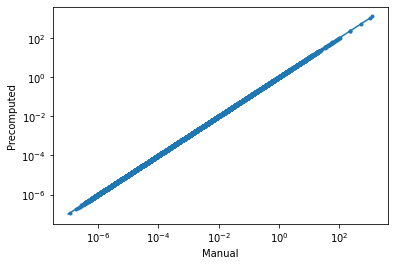

In [8]:
# Mass weights agree!
fig,ax = plt.subplots()
ax.plot([1e-7,1e3],[1e-7,1e3])
ax.scatter(ref_p_mass,precomputed_p_mass,marker='.')
ax.set_xlabel('Manual')
ax.set_ylabel('Precomputed')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

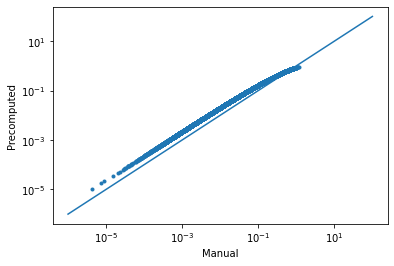

In [9]:
# Redshift weights DO NOT agree!
fig,ax = plt.subplots()
ax.plot([1e-6,1e2],[1e-6,1e2])
ax.scatter(ref_p_z,precomputed_p_z,marker='.')
ax.set_xlabel('Manual')
ax.set_ylabel('Precomputed')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [10]:
# This lack of agreement actually pointed to a mistake in my existing code,
# which is circumvented by directly reading out draw probabilities.
# The redshift evolution parameter should have been the following:
ref_kappa_minus_1 = 0.

# Redshift distribution normalization
z_grid = np.linspace(0,1.9,1000)
dVdz_grid = 4.*np.pi*Planck15.differential_comoving_volume(z_grid).to(u.Gpc**3*u.sr**(-1)).value
pz_norm = np.trapz(dVdz_grid*(1.+z_grid)**ref_kappa_minus_1,z_grid)

# Injected redshift distribution
dVdz_det = 4.*np.pi*Planck15.differential_comoving_volume(z_det).to(u.Gpc**3*u.sr**(-1)).value
ref_p_z = dVdz_det*(1.+z_det)**ref_kappa_minus_1/pz_norm

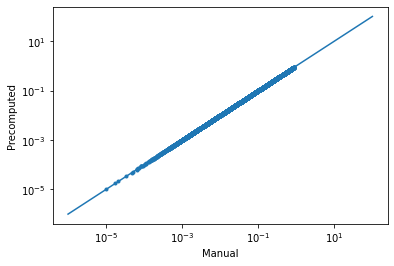

In [11]:
# Weights agree now!
fig,ax = plt.subplots()
ax.plot([1e-6,1e2],[1e-6,1e2])
ax.scatter(ref_p_z,precomputed_p_z,marker='.')
ax.set_xlabel('Manual')
ax.set_ylabel('Precomputed')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [70]:
# Now let's compute the same (partial) check for O1
snr_threshold = 12.
mockDetections_O1O2 = h5py.File('/home/reed.essick/rates+pop/o1+o2-sensitivity-estimates/LIGO-T2100280-v2/o1-bbh-IMRPhenomXPHMpseudoFourPN.hdf5','r')
snr_network = mockDetections_O1O2['events']['snr_net']
detected = (snr_network>snr_threshold)
m1_det_O1O2 = mockDetections_O1O2['events']['mass1_source'][detected]
m2_det_O1O2 = mockDetections_O1O2['events']['mass2_source'][detected]
s1x_det_O1O2 = mockDetections_O1O2['events']['spin1x'][detected]
s1y_det_O1O2 = mockDetections_O1O2['events']['spin1y'][detected]
s1z_det_O1O2 = mockDetections_O1O2['events']['spin1z'][detected]
s2x_det_O1O2 = mockDetections_O1O2['events']['spin2x'][detected]
s2y_det_O1O2 = mockDetections_O1O2['events']['spin2y'][detected]
s2z_det_O1O2 = mockDetections_O1O2['events']['spin2z'][detected]
z_det_O1O2 = mockDetections_O1O2['events']['z'][detected]

In [71]:
# Follow the O1 configuration file here:
# https://git.ligo.org/reed.essick/o1-o2-semianalytic-injections/-/blob/master/o1-bbh/o1-bbh.ini
ref_kappa_minus_1 = 0.
zMax = 2.478

# Redshift distribution normalization
z_grid = np.linspace(0,zMax,1000)
dVdz_grid = 4.*np.pi*Planck15.differential_comoving_volume(z_grid).to(u.Gpc**3*u.sr**(-1)).value
pz_norm = np.trapz(dVdz_grid,z_grid)

# Injected redshift distribution
dVdz_det = 4.*np.pi*Planck15.differential_comoving_volume(z_det_O1O2).to(u.Gpc**3*u.sr**(-1)).value
ref_p_z = dVdz_det*(1.+z_det_O1O2)**ref_kappa_minus_1/pz_norm

In [72]:
# Read out precomputed values
precomputed_lnp_z = mockDetections_O1O2['events']['logpdraw_z'][detected]
precomputed_p_z = np.exp(precomputed_lnp_z)

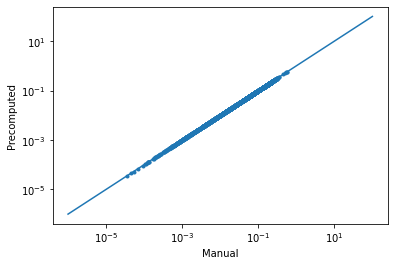

In [73]:
# Redshift weights DO NOT agree!
fig,ax = plt.subplots()
ax.plot([1e-6,1e2],[1e-6,1e2])
ax.scatter(ref_p_z,precomputed_p_z,marker='.')
ax.set_xlabel('Manual')
ax.set_ylabel('Precomputed')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [74]:
mockDetections_O1 = h5py.File('/home/reed.essick/rates+pop/o1+o2-sensitivity-estimates/LIGO-T2100280-v2/o1-bbh-IMRPhenomXPHMpseudoFourPN.hdf5','r')
mockDetections_O2 = h5py.File('/home/reed.essick/rates+pop/o1+o2-sensitivity-estimates/LIGO-T2100280-v2/o2-bbh-IMRPhenomXPHMpseudoFourPN.hdf5','r')
mockDetections_O3 = h5py.File('/home/reed.essick/rates+pop/o3-sensitivity-estimates/LIGO-T2100113-v10/endo3_bbhpop-LIGO-T2100113-v10.hdf5','r')

In [129]:
print("Total time:\t{0}".format(mockDetections_O3.attrs['analysis_time_s']))
print("Total number:\t{0}".format(mockDetections_O3.attrs['total_generated']))
print("Total accepted:\t{0}".format(mockDetections_O3.attrs['n_accepted']))
print("Injection rate:\t{0}".format(mockDetections_O3.attrs['total_generated']/mockDetections_O3.attrs['analysis_time_s']))

Total time:	28749576
Total number:	73957576
Total accepted:	284672
Injection rate:	2.572475364506245


In [131]:
print("Total time:\t{0}".format(mockDetections_O2.attrs['total_analysis_time']))
print("Total number:\t{0}".format(mockDetections_O2.attrs['total_generated']))
print("Total accepted:\t{0}".format(mockDetections_O2.attrs['num_accepted']))
print("Injection rate:\t{0}".format(mockDetections_O2.attrs['total_generated']/mockDetections_O2.attrs['total_analysis_time']))

Total time:	23176801.0
Total number:	26903453
Total accepted:	250000
Injection rate:	1.1607923371305644


In [132]:
print("Total time:\t{0}".format(mockDetections_O1.attrs['total_analysis_time']))
print("Total number:\t{0}".format(mockDetections_O1.attrs['total_generated']))
print("Total accepted:\t{0}".format(mockDetections_O1.attrs['num_accepted']))
print("Injection rate:\t{0}".format(mockDetections_O1.attrs['total_generated']/mockDetections_O1.attrs['total_analysis_time']))

Total time:	11203200.0
Total number:	23116922
Total accepted:	250000
Injection rate:	2.063421343901742
